In [1]:
!pip install swig
!pip install gym[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.5 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376418 sha256=9630fad34a9f0919ad67def64dadb0bd57aee6bd5316d6908464d27f4384d9c9
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1


In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [25]:
class PPOConfig:
    gamma = 0.99
    lam = 0.95
    clip_ratio = 0.1  # Smaller clip ratio for safer updates
    lr = 3e-4
    critic_lr = 1e-4  # Lower critic learning rate
    epochs = 10
    steps_per_episode = 4096  # More steps for better trajectory diversity
    train_iters = 100  # More iterations per episode
    entropy_coef = 0.05  # Higher entropy for exploration
    hidden_size = 256  # Larger network capacity

In [26]:

# Define separate Actor and Critic networks
class Actor(nn.Module):
    def __init__(self, obs_space, action_space, hidden_size, embedding_dim=128):
        super(Actor, self).__init__()
        self.embedding = nn.Embedding(obs_space, embedding_dim)
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_space),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        x = self.embedding(x)
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, obs_space, hidden_size, embedding_dim=128):
        super(Critic, self).__init__()
        self.embedding = nn.Embedding(obs_space, embedding_dim)
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        x = self.embedding(x)
        return self.net(x)


# Generalized Advantage Estimation (GAE)
def compute_gae(rewards, values, gamma, lam):
    advantages = []
    gae = 0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] - values[t]
        gae = delta + gamma * lam * gae
        advantages.insert(0, gae)
    returns = [adv + val for adv, val in zip(advantages, values[:-1])]
    return torch.tensor(advantages, dtype=torch.float32), torch.tensor(returns, dtype=torch.float32)


In [41]:
# Train PPO
def train_ppo(env_name, config, num_episodes=1000):
    env = gym.make(env_name)
    obs_space = env.observation_space.n
    action_space = env.action_space.n

    # Initialize actor, critic, and optimizers
    actor = Actor(obs_space, action_space, config.hidden_size)
    critic = Critic(obs_space, config.hidden_size)
    actor_optimizer = optim.Adam(actor.parameters(), lr=config.lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=config.critic_lr)

    episode_rewards = []

    for episode in range(num_episodes):
        states = []
        actions = []
        rewards = []
        log_probs = []
        values = []

        # Initialize environment for the episode
        state = env.reset()
        total_reward = 0
        done = False

        # Collect trajectories
        while not done:
            state_tensor = torch.tensor([state], dtype=torch.long)
            logits = actor(state_tensor)
            dist = Categorical(logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            value = critic(state_tensor).squeeze()

            result = env.step(action.item())
            next_state, reward, done = result[0], result[1], result[2]

            # Store trajectory data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            values.append(value.item())

            # Update reward and state
            total_reward += reward
            state = next_state

        # Store the total reward for the episode
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

        # Add value for terminal state
        state_one_hot = torch.eye(obs_space)[state].unsqueeze(0)
        terminal_value = critic(state_one_hot).squeeze().item() if not done else 0
        values.append(terminal_value)

        # Compute GAE and returns
        advantages, returns = compute_gae(rewards, values, config.gamma, config.lam)
        log_probs = torch.stack(log_probs)

        # Perform PPO updates
        for _ in range(config.train_iters):
            indices = np.random.randint(0, len(states), size=64)
            sampled_states = torch.tensor(states)[indices].long()
            sampled_actions = torch.tensor(actions)[indices]
            sampled_log_probs = log_probs[indices].detach()
            sampled_advantages = advantages[indices].detach()
            sampled_returns = returns[indices]

            # Update actor
            logits = actor(sampled_states)
            dist = Categorical(logits)
            new_log_probs = dist.log_prob(sampled_actions)
            ratio = torch.exp(new_log_probs - sampled_log_probs)
            clipped_advantages = torch.clamp(ratio, 1 - config.clip_ratio, 1 + config.clip_ratio) * sampled_advantages
            policy_loss = -(torch.min(ratio * sampled_advantages, clipped_advantages)).mean()
            entropy = dist.entropy().mean()
            actor_loss = policy_loss - config.entropy_coef * entropy

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # Update critic with value clipping
            values_old = critic(sampled_states).squeeze().detach()
            new_values = critic(sampled_states).squeeze()
            value_clipped = values_old + torch.clamp(new_values - values_old, -config.clip_ratio, config.clip_ratio)
            value_loss = torch.max(
                (new_values - sampled_returns) ** 2,
                (value_clipped - sampled_returns) ** 2
            ).mean()

            critic_optimizer.zero_grad()
            value_loss.backward()
            critic_optimizer.step()

    env.close()
    return episode_rewards


In [44]:
# Main execution
if __name__ == "__main__":
    config = PPOConfig()
    episode_rewards = train_ppo("Taxi-v3", config, num_episodes=2000)

    # Print overall average reward
    print(f"Overall Average Reward: {sum(episode_rewards) / len(episode_rewards):.2f}")


Episode 1: Total Reward = -785
Episode 2: Total Reward = -605
Episode 3: Total Reward = -884
Episode 4: Total Reward = -767
Episode 5: Total Reward = -776
Episode 6: Total Reward = -551
Episode 7: Total Reward = -911
Episode 8: Total Reward = -794
Episode 9: Total Reward = -812
Episode 10: Total Reward = -776
Episode 11: Total Reward = -839
Episode 12: Total Reward = -861
Episode 13: Total Reward = -812
Episode 14: Total Reward = -776
Episode 15: Total Reward = -812
Episode 16: Total Reward = -803
Episode 17: Total Reward = -821
Episode 18: Total Reward = -668
Episode 19: Total Reward = -893
Episode 20: Total Reward = -695
Episode 21: Total Reward = -794
Episode 22: Total Reward = -731
Episode 23: Total Reward = -794
Episode 24: Total Reward = -776
Episode 25: Total Reward = -893
Episode 26: Total Reward = -848
Episode 27: Total Reward = -393
Episode 28: Total Reward = -614
Episode 29: Total Reward = -713
Episode 30: Total Reward = -722
Episode 31: Total Reward = -812
Episode 32: Total

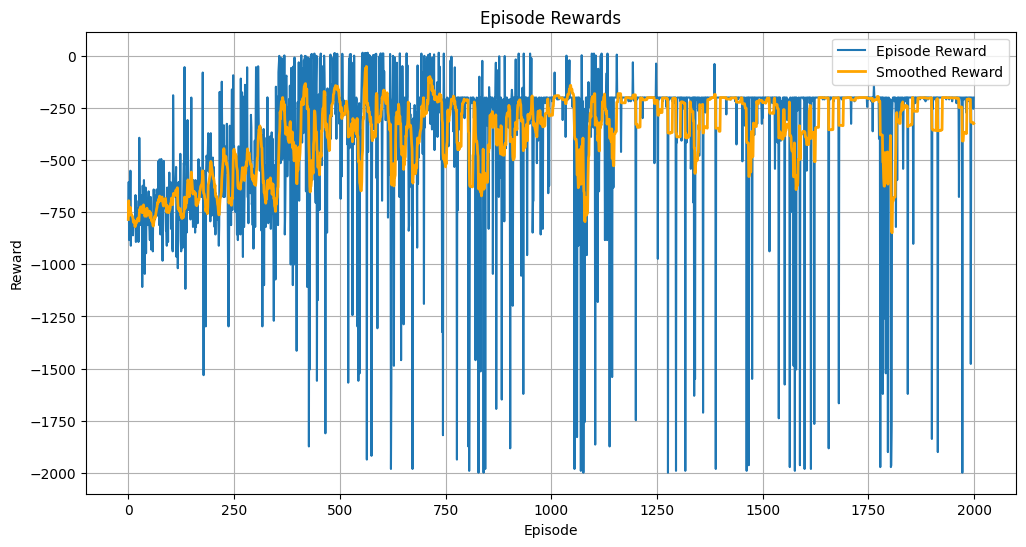

In [45]:
import matplotlib.pyplot as plt

# def rewards_timestep(score_history):
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label="Episode Reward")
smoothed_rewards = [np.mean(episode_rewards[max(0, i-10):i+1]) for i in range(len(episode_rewards))]
plt.plot(smoothed_rewards, label="Smoothed Reward", color="orange", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards")
plt.legend()
plt.grid()
plt.show()